In [70]:
from TMclass import *
import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from xml.etree import ElementTree

def flush_many(max_vol, vol_dataset, phi_mode, start, nbits, ndata, level, partition):
    global PHI
    global phi

    def _new_start(start,end):
        start += datetime.timedelta(days=1)
        start = start.replace(hour=3,minute=0,second=0)
        if end > start:
            start = end + datetime.timedelta(hours=1)
        return start
    

    vol0 = max_vol[0]
    vol1 = max_vol[1]
    n0 = int(vol0 // vol_dataset * 0.99)
    n1 = int(vol1 // vol_dataset * 0.99)

    if ndata == -1:
        ndata = phi_mode.raw.n_datasets
    
    print(f'Days needed: {(ndata-n0)//n1+2}')
    kw = phi_mode.compressing(start, nbits = nbits, ndata = n0,level=level); phi.saving(partition,**kw); PHI.saving(partition,**kw)
    # start += datetime.timedelta(days=1)
    start = _new_start(start,kw['end'])

    for i in range((ndata-n0)//n1+1):
        kw = phi_mode.compressing(start, nbits = nbits, ndata = n1,level=level); phi.saving(partition,**kw); PHI.saving(partition,**kw)
        start = _new_start(start,kw['end'])

    return (phi_mode, kw)

PHI = PHI_MEMORY(datetime.datetime.fromisoformat('2022-01-19T23:00:00'))

TM = {'date':[], 'tm_rate':[], 'duration':[]}
TMnew = {'date':[], 'tm_rate':[], 'duration':[]}

with open('../telem.xml') as f:
	tree = ElementTree.parse(f)

for node in tree.iter('PASS'):
    d = datetime.datetime.fromisoformat(node.attrib.get('comment')[:-1]).date()
    if d >= datetime.date(2022,1,1) and d <= datetime.date(2023,1,1):
        TM['date'] += [datetime.datetime.fromisoformat(node.attrib.get('comment')[:-1])]
        TM['tm_rate'] += [float(node.attrib.get('tm_rate'))]
        TM['duration'] += [int(node.attrib.get('duration'))]

with open('../EFECS_M06_V00.xml') as f:
	tree = ElementTree.parse(f)

for node in tree.iter('PASS'):
    d = datetime.datetime.strptime(node.attrib.get('time')[:-1],"%Y-%jT%H:%M:%S").date()
    if d >= datetime.date(2022,1,1) and d <= datetime.date(2023,1,1):
        TMnew['date'] += [datetime.datetime.strptime(node.attrib.get('time')[:-1],"%Y-%jT%H:%M:%S")]
        TMnew['tm_rate'] += [float(node.attrib.get('tm_rate'))]
        TMnew['duration'] += [int(node.attrib.get('duration'))]

TM['date'] = np.asarray(TM['date'])
TM['tm_rate'] = np.asarray(TM['tm_rate'])
TM['duration'] = np.asarray(TM['duration'])

TMnew['date'] = np.asarray(TMnew['date'])
TMnew['tm_rate'] = np.asarray(TMnew['tm_rate'])
TMnew['duration'] = np.asarray(TMnew['duration'])

f = open('phi.itl','r')
lines = f.readlines()

FL = {'date':[], 'flush':[]}

for x in lines:
    temp = x.split(' ')
    if 'PHI_SCI_Flush_VOL' in temp[-1]:
        FL['date'] += [datetime.datetime.fromisoformat(temp[0][:-1])]
        FL['flush'] += [float(temp[-1][19:-2])]
        # print(temp[0][:-1],temp[-1][19:-2])

FL['date'] = np.asarray(FL['date'])
FL['flush'] = np.asarray(FL['flush'])

f = open('phi.itl','r')
lines = f.readlines()

# SV = {'date':[], 'rate':[]}

# for x in lines:
#     temp = x.split(' ')
#     if 'PHI_SCI_Rate' in temp[-1]:
#         SV['date'] += [datetime.datetime.fromisoformat(temp[0][:-1])]
#         SV['rate'] += [float(temp[-1][14:-2])]
#         # print(temp[0][:-1],temp[-1][19:-2])

# SV['date'] = np.asarray(SV['date'])
# SV['rate'] = np.asarray(SV['rate'])

f = open('phi_new.itl','r')
lines = f.readlines()

FLnew = {'date':[], 'flush':[]}

for x in lines:
    temp = x.split(' ')
    if 'PHI_SCI_Flush_VOL' in temp[-1]:
        FLnew['date'] += [datetime.datetime.fromisoformat(temp[0][:-1])]
        FLnew['flush'] += [float(temp[-1][19:-2])]
        # print(temp[0][:-1],temp[-1][19:-2])

FLnew['date'] = np.asarray(FLnew['date'])
FLnew['flush'] = np.asarray(FLnew['flush'])



Text(0.5, 0, 'date')

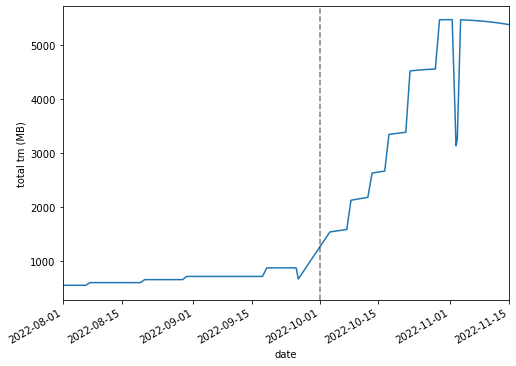

In [71]:
plt.figure(figsize=(8,6))
plt.plot(TM['date'], (TM['tm_rate']*TM['duration'])/8/1e6)#; plt.ylim(0,5000)
plt.xlim(datetime.date(2022,8,1),datetime.date(2022,11,15))
plt.gcf().autofmt_xdate()
plt.axvline(datetime.datetime(2022,10,1),color='k',linestyle='--',alpha=.5)
# plt.plot(TMnew['date'], np.cumsum(TMnew['tm_rate']*TMnew['duration']));
# plt.ylabel('total tm_rate (bit/s)')
plt.ylabel('total tm (MB)')
plt.xlabel('date')


In [72]:
TC = 0 # time for cropping
TP = 0 # time for processing
TK = 0 # time for packing
TF = 0 # time for flushing

# <span style="color:blue">CORONAL DYNAMICSs</span> <br>
08/10 - 12/10 (until 12:00)

Processing and flushing during observation

CORONAL DYNAMICS, no crop, proc
number of datasets: 16
cadence: 360 mins
duration: 4 days, 0:00:00
amount of raw-data at 32 bits: 6347.7 MiB, 396.7 MiB per dataset
processing time: 9:20:00
amount of processed data (and intermediate data) at 16 bits: 7080.1 MiB, 53.4 MiB per dataset
compressing (+ flushing) time: 0:34:30.865920
amount of compressed data + metadata at 6 bits: 246.9 MiB, 15.4 MiB per dataset
amount of metadata:  256 MiB
amount of memory usage: 13549.8 MiB



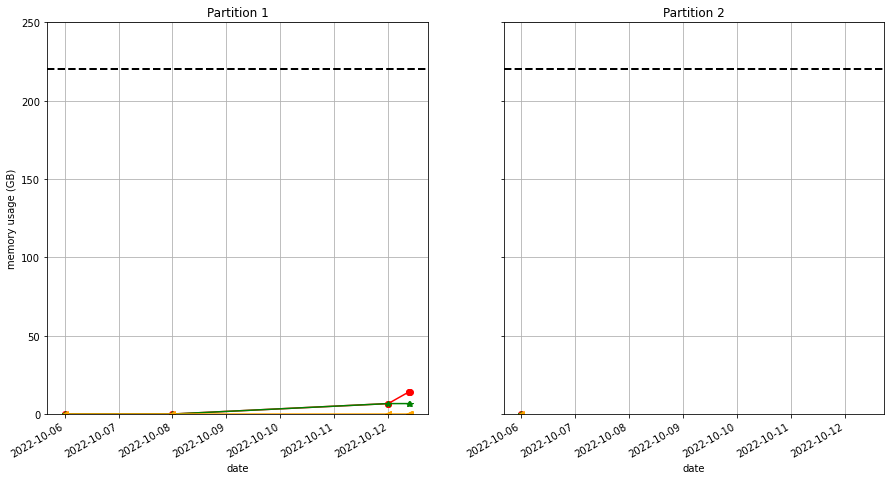

In [73]:
t0 = datetime.datetime.fromisoformat('2022-10-08T00:00:00')
t1 = datetime.datetime.fromisoformat('2022-10-12T00:00:00')
PHI = PHI_MEMORY(t0-datetime.timedelta(days=2))

M1 = PHI_MODE('FDT')
kw = M1.observation(t0,t1,cadence=6*60,shape=(2048,2048,4,6)); PHI.saving(1,**kw)
kw = M1.processing(kw['end'],ndata=-1,partialStore=0x00,nout=5,level='raw',); PHI.saving(1,**kw)
kw = M1.compressing(kw['end'],ndata=-1,nbits=6,level='proc'); PHI.saving(1,**kw)

printp(M1,label='CORONAL DYNAMICS, no crop, proc')
plot_tot(PHI,ylim=(0,250))

# PHI.format_partition(1,kw['end'] + datetime.timedelta(days=10))
# final_plot(PHI,TM)

# <span style="color:blue">DENSITY FLUCTUACTIONS</span> <br>
12/10 - 13/10 (until 12:00)

Processing and flushing during observation

DENSITY FLUCTUACTIONS, no crop, proc
number of datasets: 4
cadence: 360 mins
duration: 1 day, 0:00:00
amount of raw-data at 32 bits: 1586.9 MiB, 396.7 MiB per dataset
processing time: 2:20:00
amount of processed data (and intermediate data) at 16 bits: 1770.0 MiB, 53.4 MiB per dataset
compressing (+ flushing) time: 0:08:37.716480
amount of compressed data + metadata at 6 bits: 61.7 MiB, 15.4 MiB per dataset
amount of metadata:  64 MiB
amount of memory usage: 3387.5 MiB



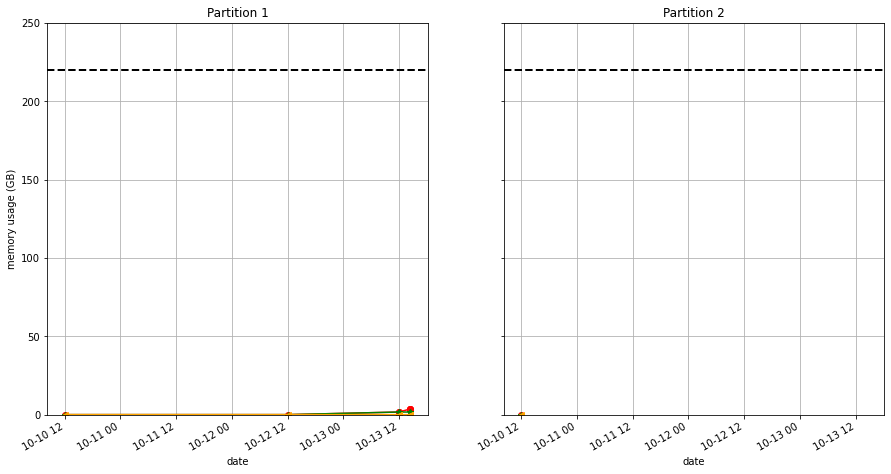

In [74]:
t0 = datetime.datetime.fromisoformat('2022-10-12T12:00:00')
t1 = datetime.datetime.fromisoformat('2022-10-13T12:00:00')
PHI = PHI_MEMORY(t0-datetime.timedelta(days=2))

M2 = PHI_MODE('FDT')
kw = M2.observation(t0,t1,cadence=6*60,shape=(2048,2048,4,6)); PHI.saving(1,**kw)
kw = M2.processing(kw['end'],ndata=-1,partialStore=0x00,nout=5,level='raw',); PHI.saving(1,**kw)
kw = M2.compressing(kw['end'],ndata=-1,nbits=6,level='proc'); PHI.saving(1,**kw)

printp(M2,label='DENSITY FLUCTUACTIONS, no crop, proc')
plot_tot(PHI,ylim=(0,250))

# PHI.format_partition(1,kw['end'] + datetime.timedelta(days=10))
# final_plot(PHI,TM)

# <span style="color:blue">RS-burst</span> <br>
13/10 (from 12:00)

30m@1m HRT + 2h50m@5m

No time for processing and flushing

RS-burst, 30m@1m + 2h50m@5m, no crop, proc
number of datasets: 64
cadence: 5 mins
duration: 2:50:00
amount of raw-data at 32 bits: 25390.6 MiB, 396.7 MiB per dataset
processing time: 1 day, 13:20:00
amount of processed data (and intermediate data) at 16 bits: 28320.3 MiB, 53.4 MiB per dataset
compressing (+ flushing) time: 2:18:03.463680
amount of compressed data + metadata at 6 bits: 987.5 MiB, 15.4 MiB per dataset
amount of metadata:  784 MiB
amount of memory usage: 54199.2 MiB



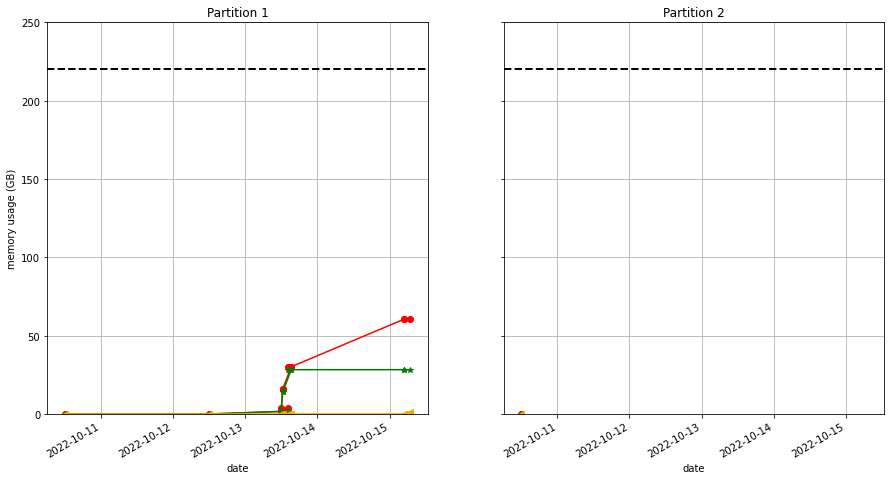

In [75]:
t0 = datetime.datetime.fromisoformat('2022-10-13T12:00:00')
t1 = datetime.datetime.fromisoformat('2022-10-13T12:30:00')

L1 = PHI_MODE('HRT')
kw = L1.observation(t0,t1,cadence=1,shape=(2048,2048,4,6)); PHI.saving(1,**kw)
kw = L1.observation(kw['end'],kw['end']+datetime.timedelta(hours=2,minutes=50),cadence=5,shape=(2048,2048,4,6)); PHI.saving(1,**kw)
kw = L1.processing(kw['end'],ndata=-1,partialStore=0x00,nout=5,level='raw',); PHI.saving(1,**kw)
kw = L1.compressing(kw['end'],ndata=-1,nbits=6,level='proc'); PHI.saving(1,**kw)

TC += (L1.proc.end - L1.proc.start).total_seconds()/60/60
TF += (L1.compr.end - L1.compr.start).total_seconds()/60/60

printp(L1,label='RS-burst, 30m@1m + 2h50m@5m, no crop, proc')
plot_tot(PHI,ylim=(0,250),time_ord=True)

# PHI.format_partition(1,kw['end'] + datetime.timedelta(days=10))
# final_plot(PHI,TM)

# <span style="color:blue">CC_OFFPOI_OOF</span> <br>
15/10 (from 18:00)

CC_OFFPOI_OOF, 4 datasets, no crop, proc
number of datasets: 3
cadence: 120 mins
duration: 6:00:00
amount of raw-data at 32 bits: 1190.2 MiB, 396.7 MiB per dataset
processing time: 1:45:00
amount of processed data (and intermediate data) at 16 bits: 1327.5 MiB, 53.4 MiB per dataset
compressing (+ flushing) time: 0:06:28.287360
amount of compressed data + metadata at 6 bits: 46.3 MiB, 15.4 MiB per dataset
amount of metadata:  48 MiB
amount of memory usage: 2540.6 MiB



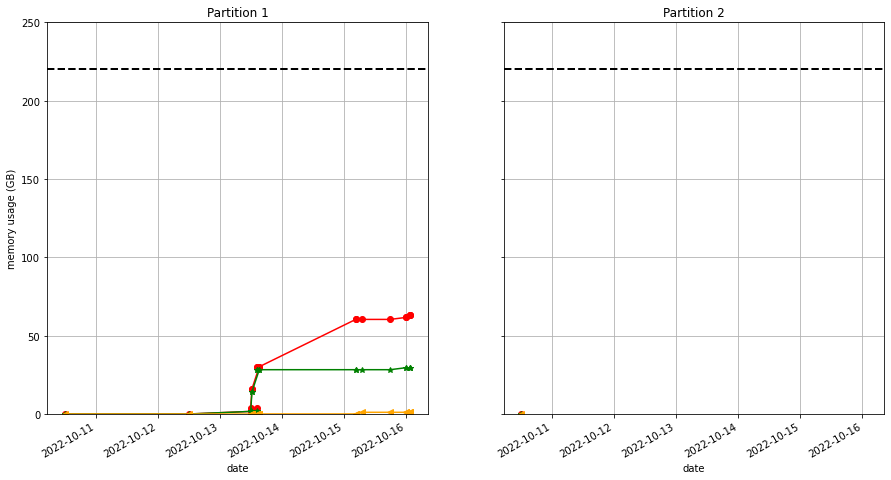

In [76]:
t0 = datetime.datetime.fromisoformat('2022-10-15T18:00:00')
t1 = datetime.datetime.fromisoformat('2022-10-16T00:00:00')

CC = PHI_MODE('FDT')
kw = CC.observation(t0,t1,cadence=120,shape=(2048,2048,4,6)); PHI.saving(1,**kw)
kw = CC.processing(kw['end'],ndata=-1,partialStore=0x00,nout=5,level='raw',); PHI.saving(1,**kw)
kw = CC.compressing(kw['end'],ndata=-1,nbits=6,level='proc'); PHI.saving(1,**kw)

printp(CC,label='CC_OFFPOI_OOF, 4 datasets, no crop, proc')
plot_tot(PHI,ylim=(0,250),time_ord=True)

# PHI.format_partition(1,kw['end'] + datetime.timedelta(days=10))
# final_plot(PHI,TM)

# <span style="color:magenta">***RESET NAND 2***</span>

In [77]:
# print('amount of compressed data + metadata in partition 1:',round(PHI.part1.compr*1e6/2**30,2), 'GiB')
# print('amount of compressed data + metadata in partition 2:',round(PHI.part2.compr*1e6/2**30,2), 'GiB')
# tm0 = datetime.datetime(2022,3,2,0,0,0)
# tm1 = datetime.datetime(2022,3,15,0,0,0)
# _ = tm_avail(tm0,tm1,df_tm,frac=.2)
print('amount of compressed data + metadata in partition 1:',round(PHI.part1.compr*1e-3,2), 'GB')
# print('amount of compressed data + metadata in partition 2:',round(PHI.part2.compr*1e-3,2), 'GB')
# print('TM time:',round((PHI.part1.compr + PHI.part2.compr)/2151.3,2), 'days')

# PHI.format_partition(1,end + datetime.timedelta(hours=1))
# phi.format_partition(1,end + datetime.timedelta(hours=1))
PHI.format_partition(1,PHI.part1.history['end'][-1] + datetime.timedelta(hours=.5))
# phi.format_partition(2,PHI.part2.history['end'][-1] + datetime.timedelta(hours=.5))
# 

amount of compressed data + metadata in partition 1: 1.15 GB


# <span style="color:blue">POLAR-OBSERVATIONS</span> <br>
16/10 (until 12:00)

80 datasets (12 hours reserved)


POLAR, 80 datasets, no crop, proc
number of datasets: 80
cadence: 2 mins
duration: 2:40:00
amount of raw-data at 32 bits: 31738.3 MiB, 396.7 MiB per dataset
processing time: 1 day, 22:40:00
amount of processed data (and intermediate data) at 16 bits: 35400.4 MiB, 53.4 MiB per dataset
compressing (+ flushing) time: 2:52:34.329600
amount of compressed data + metadata at 6 bits: 1234.3 MiB, 15.4 MiB per dataset
amount of metadata:  1280 MiB
amount of memory usage: 67749.0 MiB



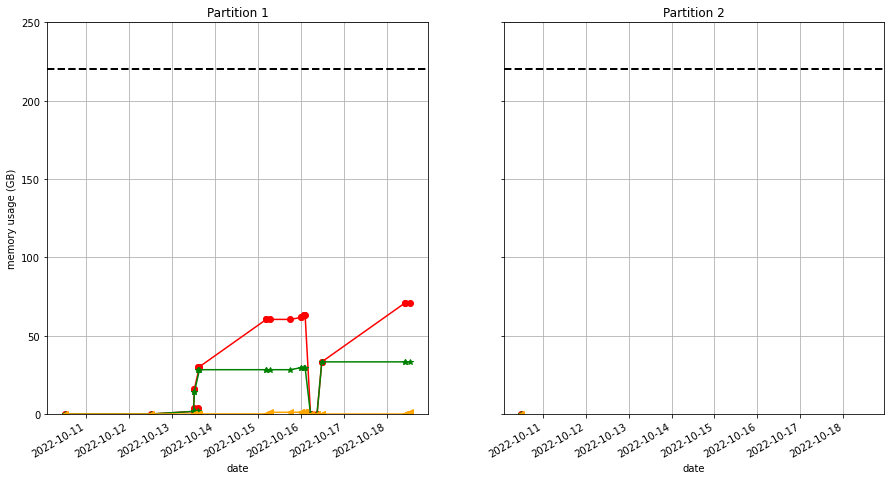

In [78]:
t0 = datetime.datetime.fromisoformat('2022-10-16T09:00:00')
# t1 = datetime.datetime.fromisoformat('2022-10-13T13:00:00')
i = 1

PO = PHI_MODE('HRT')
kw = PO.observation(t0,80,cadence=2,shape=(2048,2048,4,6)); PHI.saving(i,**kw)
kw = PO.processing(kw['end'],ndata=-1,partialStore=0x00,nout=5,level='raw',); PHI.saving(i,**kw)
kw = PO.compressing(kw['end'],ndata=-1,nbits=6,level='proc'); PHI.saving(i,**kw)

TC += (PO.proc.end - PO.proc.start).total_seconds()/60/60
TF += (PO.compr.end - PO.compr.start).total_seconds()/60/60

printp(PO,label='POLAR, 80 datasets, no crop, proc')
plot_tot(PHI,ylim=(0,250),time_ord=True)


# <span style="color:blue">AR Long Term</span> <br>
16/10 - 28/10 (from 12:00)

5d5h@30m 

6d free (17h mosaic proc, 35h spice proc, 35h polar proc, 6h flushing)

AR Long Term, 3d@30m, no crop, proc
number of datasets: 270
cadence: 60 mins
duration: 11 days, 6:00:00
amount of raw-data at 32 bits: 107116.7 MiB, 396.7 MiB per dataset
processing time: 6 days, 13:30:00
amount of processed data (and intermediate data) at 16 bits: 119476.3 MiB, 53.4 MiB per dataset
compressing (+ flushing) time: 9:42:25.862400
amount of compressed data + metadata at 6 bits: 4165.9 MiB, 15.4 MiB per dataset
amount of metadata:  4320 MiB
amount of memory usage: 228653.0 MiB



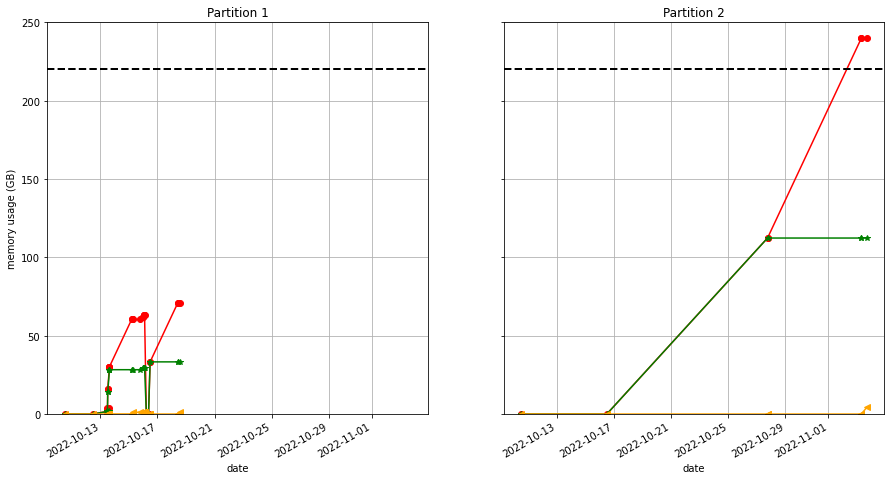

In [79]:
t0 = datetime.datetime.fromisoformat('2022-10-16T12:00:00')
t1 = datetime.datetime.fromisoformat('2022-10-27T18:00:00')
i = 2

ALp = PHI_MODE('HRT')
kw = ALp.observation(t0,t1,cadence=60,shape=(2048,2048,4,6)); PHI.saving(i,**kw); t0 = kw['end']

# ALr = PHI_MODE('HRT')
# kw = ALr.observation(t0,120,cadence=30,shape=(2048,2048,4,6)); PHI.saving(i,**kw)

kw = ALp.processing(kw['end'],ndata=-1,partialStore=0x00,nout=5,level='raw',); PHI.saving(i,**kw)
kw = ALp.compressing(kw['end'],ndata=-1,nbits=6,level='proc'); PHI.saving(i,**kw)

TC += (ALp.proc.end - ALp.proc.start).total_seconds()/60/60
TF += (ALp.compr.end - ALp.compr.start).total_seconds()/60/60

printp(ALp,label='AR Long Term, 3d@30m, no crop, proc')

# kw = ALr.packing(kw['end'],ndata=-1,level='raw',); PHI.saving(i,**kw)
# kw = ALr.compressing(kw['end'],ndata=-1,nbits=6,level='raw.pack'); PHI.saving(i,**kw)

# TK += (ALr.raw.pack.end - ALr.raw.pack.start).total_seconds()/60/60
# TF += (ALr.compr.pack.end - ALr.compr.pack.start).total_seconds()/60/60

# printp(ALr,label='AR Long Term, 3d@30m, no crop, raw')

plot_tot(PHI,ylim=(0,250),time_ord=True)

# <span style="color:blue">ATMOSPHERIC-DYNIMICS-STRUCTURE</span> <br>
27/10 (18:00-22:00)


AR-HRES-RSW1, 2d@10m, no crop, proc
number of datasets: 240
cadence: 1 mins
duration: 4:00:00
amount of raw-data at 32 bits: 49438.5 MiB, 206.0 MiB per dataset
amount of crop-data at 32 bits: 25634.8 MiB, 106.8 MiB per dataset
cropping time: 2:58:04.320000
amount of pack-data at 16 bits: 14648.4 MiB, 61.0 MiB per dataset
packing time: 2:45:45.984000
compressing (+ flushing) time: 10:04:16.066560
amount of compressed data + metadata at 6 bits: 4322.1 MiB, 18.0 MiB per dataset
amount of metadata:  5760 MiB
amount of memory usage: 89721.7 MiB



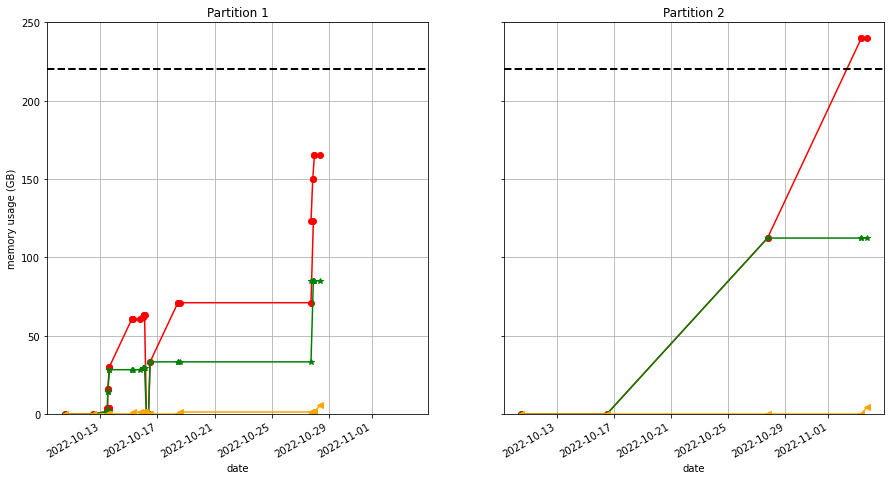

In [80]:
t0 = datetime.datetime.fromisoformat('2022-10-27T18:00:00')
t1 = datetime.datetime.fromisoformat('2022-10-27T22:00:00')
i = 1

AR1 = PHI_MODE('HRT')
kw = AR1.observation(t0,t1,cadence=1,shape=(2048,1024,4,6)); PHI.saving(i,**kw)
kw = AR1.cropping(t0,[1024,1024],ndata=-1,level='raw'); PHI.saving(i,**kw)
kw = AR1.packing(kw['end'],ndata=-1,level='raw.crop',); PHI.saving(i,**kw)
kw = AR1.compressing(kw['end'],ndata=-1,nbits=6,level='raw.pack'); PHI.saving(i,**kw)

printp(AR1,label='AR-HRES-RSW1, 2d@10m, no crop, proc')
plot_tot(PHI,ylim=(0,250))


# <span style="color:blue">CH-BOUNDARY-EXPANSION</span> <br>
28/10

Processing and flushing during observation

20h free for flush all data in partition 1

METIS 2, 1d@6h, no crop, proc
number of datasets: 4
cadence: 360 mins
duration: 1 day, 0:00:00
amount of raw-data at 32 bits: 1586.9 MiB, 396.7 MiB per dataset
processing time: 2:20:00
amount of processed data (and intermediate data) at 16 bits: 1770.0 MiB, 53.4 MiB per dataset
compressing (+ flushing) time: 0:08:37.716480
amount of compressed data + metadata at 6 bits: 61.7 MiB, 15.4 MiB per dataset
amount of metadata:  64 MiB
amount of memory usage: 3387.5 MiB



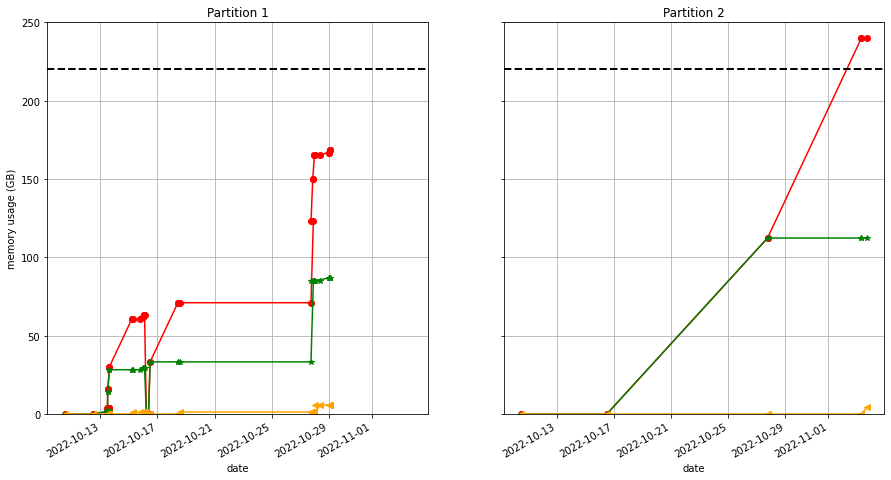

In [81]:
t0 = datetime.datetime.fromisoformat('2022-10-28T00:00:00')
t1 = datetime.datetime.fromisoformat('2022-10-29T00:00:00')
i = 1

M2 = PHI_MODE('FDT')
kw = M2.observation(t0,t1,cadence=6*60,shape=(2048,2048,4,6)); PHI.saving(i,**kw)
kw = M2.processing(kw['end'],ndata=-1,partialStore=0x00,nout=5,level='raw'); PHI.saving(i,**kw)
kw = M2.compressing(kw['end'],ndata=-1,nbits=6,level='proc'); PHI.saving(i,**kw)

printp(M2,label='METIS 2, 1d@6h, no crop, proc')
plot_tot(PHI,ylim=(0,250))

# PHI.format_partition(1,kw['end'] + datetime.timedelta(days=10))
# final_plot(PHI,TM)

<span style="color:RED">***2 DAYS NEEDED FOR PROCESSING AND FLUSHING PARTITION 1 (POLAR AND DYNAMICS)***</span> <br>

In [82]:
PHI.format_partition(1,datetime.datetime(2022,10,31,12,0,0))

# <span style="color:blue">ATMOSPHERIC-DYNIMICS-STRUCTURE</span> <br>
3/11 (09:00-16:00)


ATMOSPHERIC-DYNIMICS-STRUCTURE 1, 6h@1m, no crop, raw
number of datasets: 360
cadence: 1 mins
duration: 6:00:00
amount of raw-data at 32 bits: 142822.3 MiB, 396.7 MiB per dataset
amount of pack-data at 16 bits: 74157.7 MiB, 206.0 MiB per dataset
packing time: 8:22:50.304000
compressing (+ flushing) time: 2 days, 12:24:18.639360
amount of compressed data + metadata at 6 bits: 25923.1 MiB, 72.0 MiB per dataset
amount of metadata:  5760 MiB
amount of memory usage: 216980.0 MiB



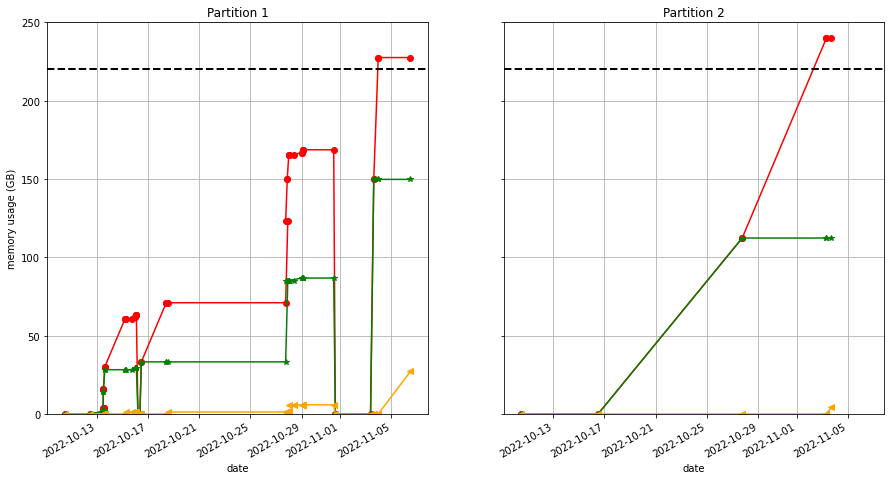

In [83]:
t0 = datetime.datetime.fromisoformat('2022-11-03T09:00:00')
t1 = datetime.datetime.fromisoformat('2022-11-03T15:00:00')
i = 1

AR2 = PHI_MODE('HRT')
kw = AR2.observation(t0,t1,cadence=1,shape=(2048,2048,4,6)); PHI.saving(i,**kw)
# kw = AR2.cropping(t0,[1024,1024],ndata=-1,level='raw'); PHI.saving(i,**kw)
kw = AR2.packing(kw['end'],ndata=-1,level='raw',); PHI.saving(i,**kw)
kw = AR2.compressing(kw['end'],ndata=-1,nbits=6,level='raw.pack'); PHI.saving(i,**kw)

printp(AR2,label='ATMOSPHERIC-DYNIMICS-STRUCTURE 1, 6h@1m, no crop, raw')
plot_tot(PHI,ylim=(0,250))


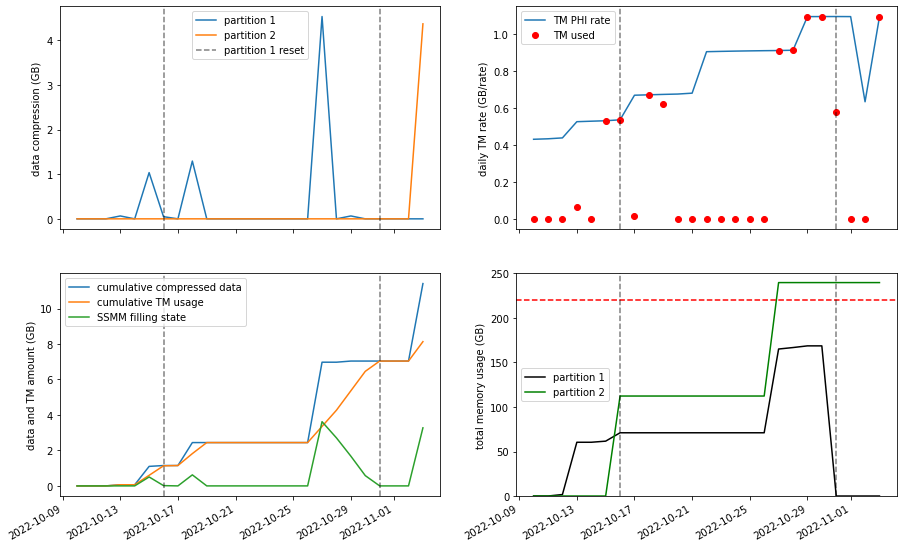

In [54]:
final_plot(PHI,TM)

# <span style="color:blue">MOSAIC</span> <br>
13/10 - 15/10 (until 18:00)

40 datasets

41 hours free (processing LOOP SOOP)

Mosaic, 40 datasets, no crop, proc
number of datasets: 40
cadence: 10 mins
duration: 6:40:00
amount of raw-data at 32 bits: 15869.1 MiB, 396.7 MiB per dataset
processing time: 23:20:00
amount of processed data (and intermediate data) at 16 bits: 17700.2 MiB, 53.4 MiB per dataset
compressing (+ flushing) time: 1:26:17.164800
amount of compressed data + metadata at 6 bits: 617.2 MiB, 15.4 MiB per dataset
amount of metadata:  640 MiB
amount of memory usage: 33874.5 MiB



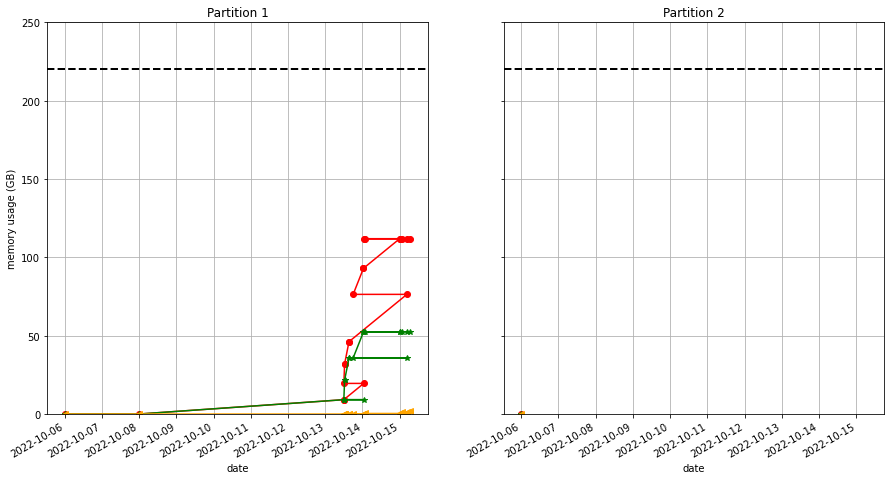

In [18]:
t0 = datetime.datetime.fromisoformat('2022-10-13T18:00:00')
# t1 = datetime.datetime.fromisoformat('2022-10-13T13:00:00')

CM = PHI_MODE('HRT')
kw = CM.observation(t0,40,cadence=10,shape=(2048,2048,4,6)); PHI.saving(1,**kw)
kw = CM.processing(kw['end'],ndata=-1,partialStore=0x00,nout=5,level='raw',); PHI.saving(1,**kw)
kw = CM.compressing(kw['end'],ndata=-1,nbits=6,level='proc'); PHI.saving(1,**kw)

TC += (CM.proc.end - CM.proc.start).total_seconds()/60/60
TF += (CM.compr.end - CM.compr.start).total_seconds()/60/60

printp(CM,label='Mosaic, 40 datasets, no crop, proc')
plot_tot(PHI,ylim=(0,250),time_ord=True)
